<a href="https://colab.research.google.com/github/LightningFryer/pytorch-english-char-model/blob/main/EnglishCharacterRegModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
path = kagglehub.dataset_download("mohneesh7/english-alphabets")

print("Path to dataset files:", path)
print("Dataset laoding complete")

Path to dataset files: /kaggle/input/english-alphabets
Dataset laoding complete


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 2.0.2
Pandas version 2.2.2


In [ ]:
# Creating the Dataset class

class EnglishCharacterDataset(Dataset):
  def __init__(self, data_dir, transform = None):
    self.data = ImageFolder(data_dir, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return self.data[index]

  @property
  def classes(self):
    return self.data.classes

Length of dataset:  6831


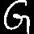

In [ ]:
from random import randint

dataset = EnglishCharacterDataset(data_dir="/kaggle/input/english-alphabets/english_alphabets")

# Test to see if dataset loads
print("Length of dataset: ", len(dataset))
image, label = dataset[randint(0, len(dataset) - 1)]
image

In [ ]:
# Sample of using Transform to resize all images to be of same dimensions
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

data_dir = '/kaggle/input/english-alphabets/english_alphabets'
# Making a dataset with the custom transform
dataset = EnglishCharacterDataset(data_dir = data_dir, transform = transform)

# Pulling a sample image to test
image, label = dataset[1000]
image.shape # Gives the dimensions of the image (now converted to a tensor with uniform dimensions)

torch.Size([3, 32, 32])

In [ ]:
for image, label in dataset:
    break

In [ ]:
# Making a dataloader in order to create batches to train
dataloader = DataLoader(dataset, batch_size = 32, shuffle=True)

# Testing by iterating and breaking, we'll be using images as the testing in the model down below
for images, labels in dataloader:
  break

In [ ]:
# Creating the classifier (untrained base model) to train from timm, the model class is called a 'Classifier' dunno why
class EnglishCharacterClassifier(nn.Module):
  def __init__(self, numClasses=26): # numClasses here is 26 because of 26 letters in the english alphabet
    super(EnglishCharacterClassifier, self).__init__()
    self.base_model = timm.create_model('resnet18', pretrained=True)
    self.base_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.base_model.maxpool = nn.Identity()
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, numClasses)
    )

  def forward(self, x):
    x = self.features(x)
    output = self.classifier(x)

    return output


In [ ]:
# Creating a new model from the classifier above
model = EnglishCharacterClassifier(numClasses=26)
# print(model)

# Testing the model by passing one 'images' batch from the dataloader test from above
model(images) # Should output a tensor if works
output = model(images)
print(output.shape)

torch.Size([32, 26])


In [ ]:
for images, labels in dataloader:
  break

# TRAINING THE MODEL STARTS HERE
# First we need to make 2 things: a loss function (called a criterion) and an optimizer
model = EnglishCharacterClassifier(numClasses=26)
model(images)
output = model(images)
print(output.shape)

criterion = nn.CrossEntropyLoss();
optimizer = optim.Adam(model.parameters(), lr = 0.001)

criterion(output, labels)

torch.Size([32, 26])


tensor(3.2355, grad_fn=<NllLossBackward0>)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

trainFolder = "/kaggle/input/english-alphabets/english_alphabets"
validFolder = "/kaggle/input/english-alphabets/english_alphabets"

trainDataset = EnglishCharacterDataset(data_dir = trainFolder, transform=transform)
validDataset = EnglishCharacterDataset(data_dir = validFolder, transform=transform)

trainDataLoader = DataLoader(trainDataset, batch_size=32, shuffle=True)
validDataLoader = DataLoader(validDataset, batch_size=32, shuffle=False)

# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = EnglishCharacterClassifier(numClasses=26)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
  model.train() #!!!!!!!!!!!!!!!!!!!
  runningLoss = 0.0
  for images, labels in tqdm(trainDataLoader, desc='Training loop'):
    # Move inputs and labels to the device
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    runningLoss += loss.item() * labels.size(0)
  train_loss = runningLoss / len(trainDataLoader.dataset)
  train_losses.append(train_loss)

  # Validation phase
  model.eval()
  running_loss = 0.0

  with torch.no_grad():
    for images, labels in tqdm(validDataLoader, desc='Validation loop'):
      # Move inputs and labels to the device
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * labels.size(0)

    val_loss = running_loss / len(validDataLoader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

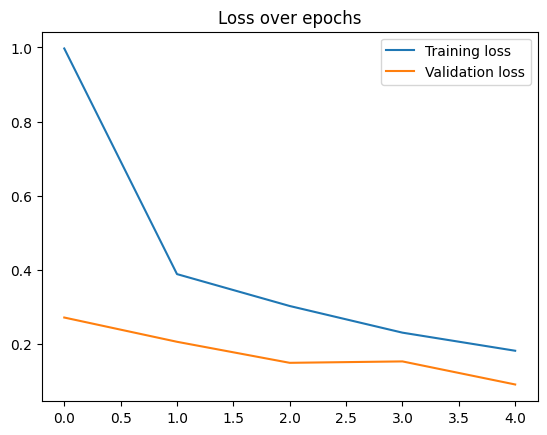

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [ ]:
# Testing the trained model

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

test_image = "/kaggle/input/english-alphabets/X/1065.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)